<a href="https://colab.research.google.com/github/windopper/NerualNetworkPracticeInJupyter/blob/main/transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

사전 훈련된 가중치 다운

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
  -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-01-25 15:45:47--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.81.208, 142.250.188.48, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.81.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  93.0MB/s    in 0.9s    

2022-01-25 15:45:49 (93.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



reference 

<a>https://codetorial.net/tensorflow/transfer_learning.html

In [ ]:

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)

for ls in pre_trained_model.layers:
  ls.trainable = False

pre_trained_model.summary()

In [17]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shepe: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shepe:  (None, 7, 7, 768)


모델 구성

In [18]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

학습 데이터 가져오기

In [6]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2022-01-25 16:01:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.217.2.112, 142.251.45.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   104MB/s    in 0.6s    

2022-01-25 16:01:29 (104 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



데이터 어그멘테이션

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '../tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


모델 훈련

In [19]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_steps=50,
    verbose=2
)

Epoch 1/20
100/100 - 209s - loss: 0.3489 - accuracy: 0.8605 - val_loss: 0.1243 - val_accuracy: 0.9530 - 209s/epoch - 2s/step
Epoch 2/20
100/100 - 186s - loss: 0.2239 - accuracy: 0.9100 - val_loss: 0.1541 - val_accuracy: 0.9430 - 186s/epoch - 2s/step
Epoch 3/20
100/100 - 143s - loss: 0.2057 - accuracy: 0.9165 - val_loss: 0.1063 - val_accuracy: 0.9550 - 143s/epoch - 1s/step
Epoch 4/20
100/100 - 138s - loss: 0.1763 - accuracy: 0.9330 - val_loss: 0.0944 - val_accuracy: 0.9640 - 138s/epoch - 1s/step
Epoch 5/20
100/100 - 139s - loss: 0.1726 - accuracy: 0.9345 - val_loss: 0.1091 - val_accuracy: 0.9610 - 139s/epoch - 1s/step
Epoch 6/20
100/100 - 139s - loss: 0.1469 - accuracy: 0.9425 - val_loss: 0.1370 - val_accuracy: 0.9540 - 139s/epoch - 1s/step
Epoch 7/20
100/100 - 138s - loss: 0.1434 - accuracy: 0.9525 - val_loss: 0.1258 - val_accuracy: 0.9560 - 138s/epoch - 1s/step
Epoch 8/20
100/100 - 139s - loss: 0.1445 - accuracy: 0.9440 - val_loss: 0.1153 - val_accuracy: 0.9620 - 139s/epoch - 1s/step


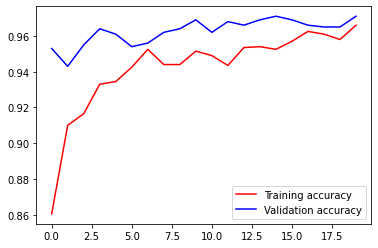

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()